In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pdb
from tqdm import tqdm

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import math

import sys
sys.path.insert(0, './src')
from data import Dataset
from layers import BBBLinear

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [3]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_device(device)
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1337)

In [4]:
class LastLayerBNN(nn.Module):
    def __init__(self, in_features, last_features=10, aux={}):
        super().__init__()

        self.layer1 = nn.Linear(in_features, 4*in_features)
        self.layer2 = nn.Linear(4*in_features, last_features)
        self.layer3 = BBBLinear(last_features, 1, aux=aux)

    def get_kl(self):
        return self.layer3.get_kl()

    def forward(self, input, sample=True):
        h = F.softplus(self.layer1(input))
        h = F.softplus(self.layer2(h))
        h = self.layer3(h, sample=sample)
        
        return h

In [5]:
class BNN(nn.Module):
    def __init__(self, in_features, last_features=10, aux={}):
        super().__init__()

        self.layer1 = BBBLinear(in_features, 4*in_features, aux=aux)
        self.layer2 = BBBLinear(4*in_features, last_features, aux=aux)
        self.layer3 = BBBLinear(last_features, 1, aux=aux)

    def get_kl(self):
        return self.layer1.get_kl() + self.layer2.get_kl() + self.layer3.get_kl()

    def forward(self, input, sample=True):
#         pdb.set_trace()
        h = F.leaky_relu(self.layer1(input, sample=sample))
        h = F.leaky_relu(self.layer2(h, sample=sample))
        h = self.layer3(h, sample=sample)
        
        return h

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [7]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['dataset_name'] = 'boston_housing'
# args['var_family_type'] = 'IAF'
if args['dataset_name'].find('mnist') > -1:
    args['num_epoches'] = 201
    args['print_info'] = 50
    args['n_IS'] = 10000
    
    args['train_batch_size'] = 100
    args['val_dataset'] = 10000
    args['val_batch_size'] = 100
    args['test_batch_size'] = 100
else:
    args['n_IS'] = 2000
    args['num_epoches'] = 10001
    args['print_info'] = 1000
    args['train_batch_size'] = 100
    args['val_dataset'] = 100
    args['val_batch_size'] = 20
    args['test_batch_size'] = 10

In [8]:
dataset = Dataset(args)
dataset.in_features[0]

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 406


13

In [9]:
num_batches = math.ceil(dataset.train_ans.shape[0] / args['train_batch_size'])

In [10]:
model = BNN(in_features=dataset.in_features[0], aux=args).to(device) #,  'var_family_type': 'IAF'

In [11]:
params = list(model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.75)

best_mse = float('inf')
best_KL = float('inf')
current_tol = 0


for ep in tqdm(range(args.num_epoches)):
    for x_train, y_train_labels in dataset.next_train_batch():
        preds = model(x_train)
        
        log_likelihood = torch.distributions.Normal(loc=preds, scale=torch.tensor(1., device=device,
                                                                                  dtype=args.torchType)).log_prob(y_train_labels).sum()
        KL = model.get_kl()
        elbo = log_likelihood - KL / num_batches
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    if ep % args.print_info == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        score_total = []
        with torch.no_grad():
            for x_val, y_val_labels in dataset.next_val_batch():
                logits = model(x_val)
                score = ((logits - y_val_labels)**2).mean().cpu().numpy()
                score_total.append(score)
        print(f"Mean validation MSE at epoch number {ep} is {np.array(score_total).mean()}")
        print(f'Current KL is {KL.cpu().detach().numpy()}')

  0%|          | 5/10001 [00:00<23:22,  7.13it/s]

ELBO value is -34985148.0 on epoch number 0
Mean validation MSE at epoch number 0 is 148353040.0
Current KL is 1271.9462890625


 10%|█         | 1005/10001 [00:27<04:06, 36.56it/s]

ELBO value is -1617.9808349609375 on epoch number 1000
Mean validation MSE at epoch number 1000 is 2058.519775390625
Current KL is 1916.79248046875


 20%|██        | 2005/10001 [00:54<03:41, 36.17it/s]

ELBO value is -1326.722412109375 on epoch number 2000
Mean validation MSE at epoch number 2000 is 398.462890625
Current KL is 1855.5462646484375


 30%|███       | 3005/10001 [01:21<03:12, 36.29it/s]

ELBO value is -557.5418090820312 on epoch number 3000
Mean validation MSE at epoch number 3000 is 102.37725830078125
Current KL is 1992.263916015625


 40%|████      | 4005/10001 [01:48<02:45, 36.19it/s]

ELBO value is -453.94671630859375 on epoch number 4000
Mean validation MSE at epoch number 4000 is 56.94786834716797
Current KL is 1766.805908203125


 50%|█████     | 5005/10001 [02:16<02:17, 36.37it/s]

ELBO value is -487.89794921875 on epoch number 5000
Mean validation MSE at epoch number 5000 is 41.73921203613281
Current KL is 1708.229248046875


 60%|██████    | 6005/10001 [02:43<01:49, 36.34it/s]

ELBO value is -563.3121337890625 on epoch number 6000
Mean validation MSE at epoch number 6000 is 48.380977630615234
Current KL is 2263.760009765625


 70%|███████   | 7005/10001 [03:10<01:22, 36.37it/s]

ELBO value is -419.4985046386719 on epoch number 7000
Mean validation MSE at epoch number 7000 is 29.21498680114746
Current KL is 1861.519287109375


 80%|████████  | 8005/10001 [03:37<00:55, 36.21it/s]

ELBO value is -325.6415710449219 on epoch number 8000
Mean validation MSE at epoch number 8000 is 29.729822158813477
Current KL is 1480.320068359375


 90%|█████████ | 9005/10001 [04:05<00:27, 36.24it/s]

ELBO value is -297.8284912109375 on epoch number 9000
Mean validation MSE at epoch number 9000 is 19.87674331665039
Current KL is 1375.8782958984375


100%|██████████| 10001/10001 [04:32<00:00, 36.69it/s]

ELBO value is -285.6047058105469 on epoch number 10000
Mean validation MSE at epoch number 10000 is 17.36181640625
Current KL is 1305.8914794921875


In [8]:
def plot_pred_to_true(args, model, dataset, name=''):
    '''
    The function plots prediction values (with predicted variance) versus true ones
    '''
    device = args.device
    torchType = args.torchType
    
    examples = torch.tensor([], device=device, dtype=torchType)
    true_ans = torch.tensor([], device=device, dtype=torchType)
    pred_ans = torch.tensor([], device=device, dtype=torchType)
    pred_std = torch.tensor([], device=device, dtype=torchType)
    
    with torch.no_grad():
        for val_batch, val_label in tqdm(dataset.next_val_batch()):
            pred_matrix = torch.empty((args.n_IS, val_batch.shape[0]), device=device, dtype=torchType)
            for i in range(args.n_IS):
                preds = model(val_batch)
                pred_matrix[i, :] = preds.view(-1)
            means = pred_matrix.mean(0)
            stds = pred_matrix.std(0)
            examples = torch.cat([examples, val_batch], dim=0)
            true_ans = torch.cat([true_ans, val_label.squeeze()], dim=0)
            pred_ans = torch.cat([pred_ans, means], dim=0)
            pred_std = torch.cat([pred_std, stds], dim=0)
        idx = torch.argsort(true_ans)
        examples = examples[idx].cpu().numpy()
        true_ans = true_ans[idx].cpu().numpy()
        pred_ans = pred_ans[idx].cpu().numpy()
        pred_std = pred_std[idx].cpu().numpy()
        
        plt.figure(figsize=(15, 8), dpi=300)
        plt.title(name)
        plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
        plt.plot(true_ans, pred_ans, '-..')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.axis('equal')
        plt.xlim(true_ans.min(), true_ans.max())
        plt.ylim(true_ans.min(), true_ans.max())
        plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./figs/{name}.png', format='png')
        plt.show();
        return examples, true_ans, pred_ans, pred_std

5it [00:06,  1.31s/it]


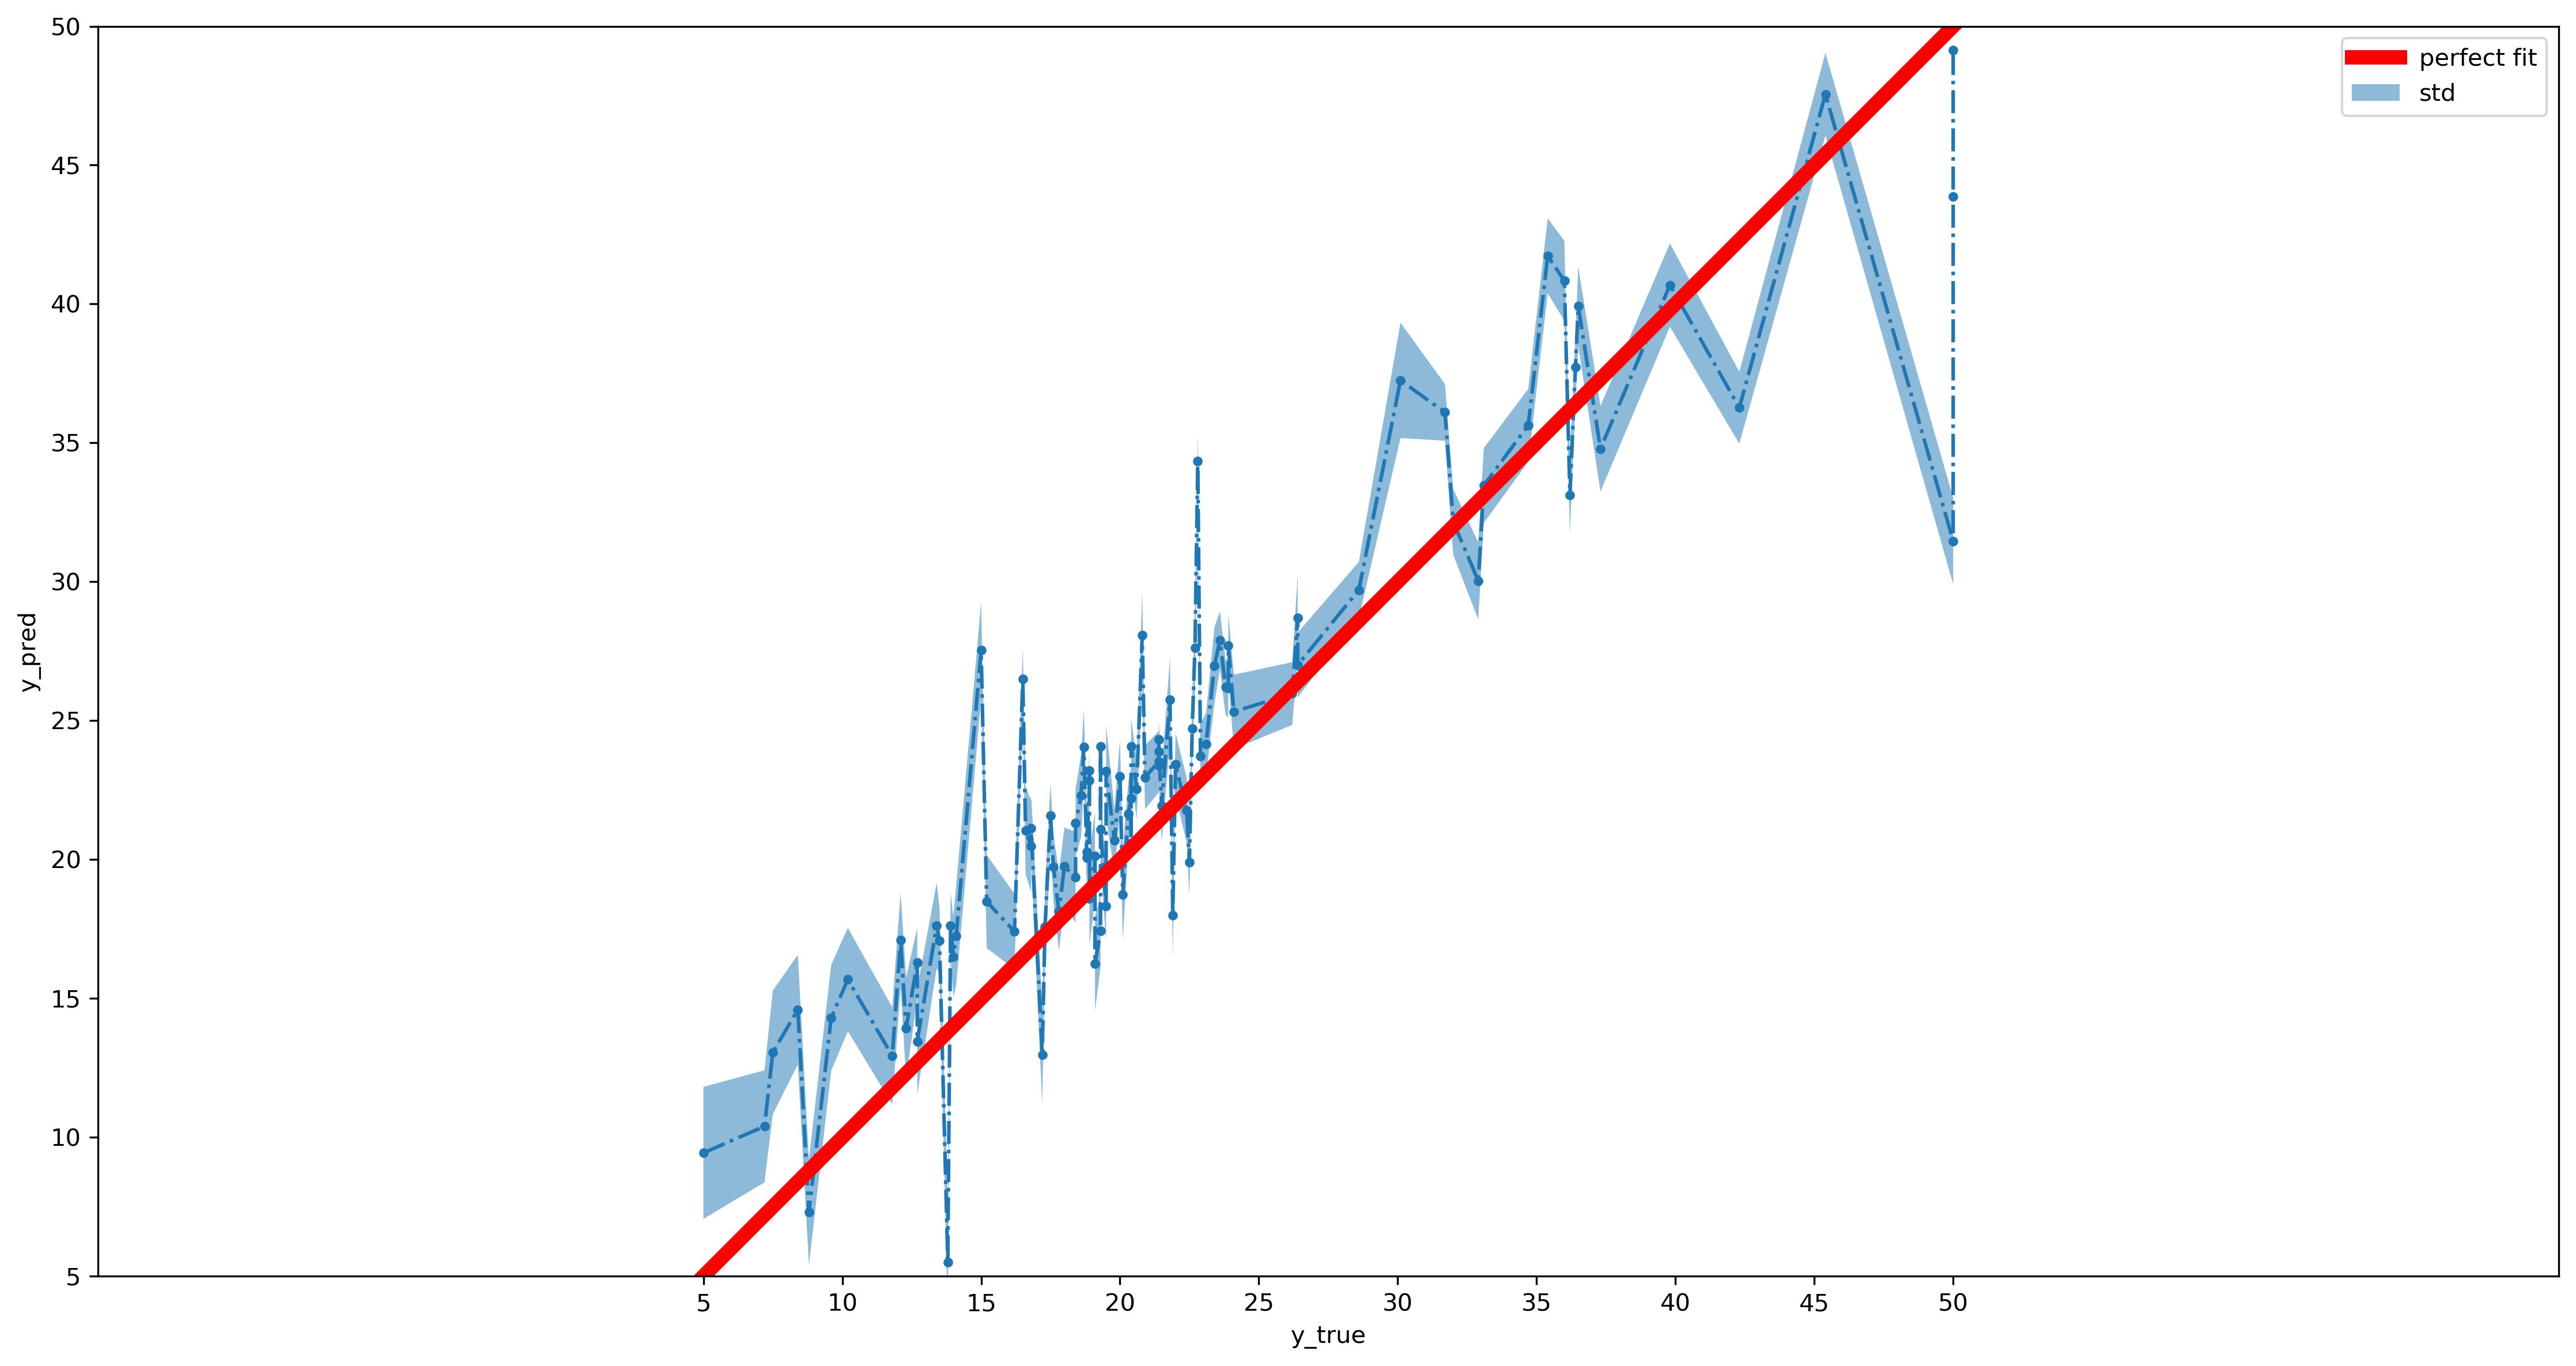

In [13]:
plot_pred_to_true(args, model, dataset);

In [1]:
import sys
sys.path.insert(0, './new_src')

from varfamily import IAF, MeanField
from data import Dataset
from layers import BLinear
from trainer import train_vi_regression_kl_explicit
from priors import StandardNormal

from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda:0'

In [3]:
dataset = Dataset('boston_housing', device, train_batch_size=100)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 404


In [4]:
class BNN(nn.Module):
    def __init__(self, in_features, last_features=10, bias=True, vf_class=MeanField, **kwargs):
        super().__init__()

        self.layer1 = BLinear(in_features, 4*in_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer2 = BLinear(4*in_features, last_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer3 = BLinear(last_features, 1, bias=True, vf_class=vf_class, **kwargs)

    def log_prob(self):
        return self.layer1.log_prob() + self.layer2.log_prob() + self.layer3.log_prob()

    def forward(self, input, sample=True):
        h = F.leaky_relu(self.layer1(input, sample=sample))
        h = F.leaky_relu(self.layer2(h, sample=sample))
        h = self.layer3(h, sample=sample)
        return h

In [5]:
model = BNN(in_features=dataset.in_features[0], vf_class=IAF, t=1).to(device)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/pyro/nn/auto_reg_nn.py:163: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn('ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.')


In [6]:
prior = StandardNormal()

In [ ]:
train_vi_regression_kl_explicit(model, prior, dataset, device, num_epochs=5000, )

  1%|          | 51/5000 [00:04<07:24, 11.14it/s]

Epoch 50 | ELBO [-1.6315076e+14] | LL -163151211397120.0 | KL [-2.255223e+09]
MSE 59498567827456.0


  2%|▏         | 101/5000 [00:09<07:15, 11.25it/s]

Epoch 100 | ELBO [-3.842175e+12] | LL -3843423207424.0 | KL [-6.241468e+09]
MSE 10433576566784.0


  3%|▎         | 151/5000 [00:13<07:09, 11.30it/s]

Epoch 150 | ELBO [8.480504e+22] | LL -18960418340864.0 | KL [-4.240252e+23]
MSE 1465495060480.0


  4%|▍         | 201/5000 [00:17<07:11, 11.12it/s]

Epoch 200 | ELBO [9.123866e+22] | LL -40966564085760.0 | KL [-4.5619328e+23]
MSE 5179230388224.0


  5%|▌         | 251/5000 [00:22<07:06, 11.12it/s]

Epoch 250 | ELBO [9.093627e+22] | LL -221773332480.0 | KL [-4.5468133e+23]
MSE 4970081943552.0


  6%|▌         | 301/5000 [00:26<07:02, 11.12it/s]

Epoch 300 | ELBO [8.999135e+22] | LL -186568032256.0 | KL [-4.4995676e+23]
MSE 2517813952512.0


  7%|▋         | 351/5000 [00:30<06:59, 11.08it/s]

Epoch 350 | ELBO [8.9423105e+22] | LL -113292165120.0 | KL [-4.4711553e+23]
MSE 632418729984.0


  8%|▊         | 401/5000 [00:35<06:56, 11.05it/s]

Epoch 400 | ELBO [1.0063871e+23] | LL -495712337920.0 | KL [-5.0319353e+23]
MSE 340523581440.0


  9%|▉         | 451/5000 [00:39<06:51, 11.05it/s]

Epoch 450 | ELBO [1.0016515e+23] | LL -185474744320.0 | KL [-5.0082575e+23]
MSE 1809322737664.0


  9%|▉         | 465/5000 [00:41<06:42, 11.27it/s]

In [8]:
def plot_pred_to_true(model, dataset, name=''):
    '''
    The function plots prediction values (with predicted variance) versus true ones
    '''
    torchType = torch.float32
    n_IS = 1000
    
    examples = torch.tensor([], device=device, dtype=torchType)
    true_ans = torch.tensor([], device=device, dtype=torchType)
    pred_ans = torch.tensor([], device=device, dtype=torchType)
    pred_std = torch.tensor([], device=device, dtype=torchType)
    
    with torch.no_grad():
        for val_batch, val_label in tqdm(dataset.val_dataloader):
            pred_matrix = torch.empty((n_IS, val_batch.shape[0]), device=device, dtype=torchType)
            for i in range(n_IS):
                preds = model(val_batch)
                pred_matrix[i, :] = preds.view(-1)
            means = pred_matrix.mean(0)
            stds = pred_matrix.std(0)
            examples = torch.cat([examples, val_batch], dim=0)
            true_ans = torch.cat([true_ans, val_label.squeeze()], dim=0)
            pred_ans = torch.cat([pred_ans, means], dim=0)
            pred_std = torch.cat([pred_std, stds], dim=0)
        idx = torch.argsort(true_ans)
        examples = examples[idx].cpu().numpy()
        true_ans = true_ans[idx].cpu().numpy()
        pred_ans = pred_ans[idx].cpu().numpy()
        pred_std = pred_std[idx].cpu().numpy()
        
        plt.figure(figsize=(15, 8), dpi=300)
        plt.title(name)
        plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
        plt.plot(true_ans, pred_ans, '-..')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.axis('equal')
        plt.xlim(true_ans.min(), true_ans.max())
        plt.ylim(true_ans.min(), true_ans.max())
        plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./figs/{name}.png', format='png')
        plt.show();
        return examples, true_ans, pred_ans, pred_std

100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


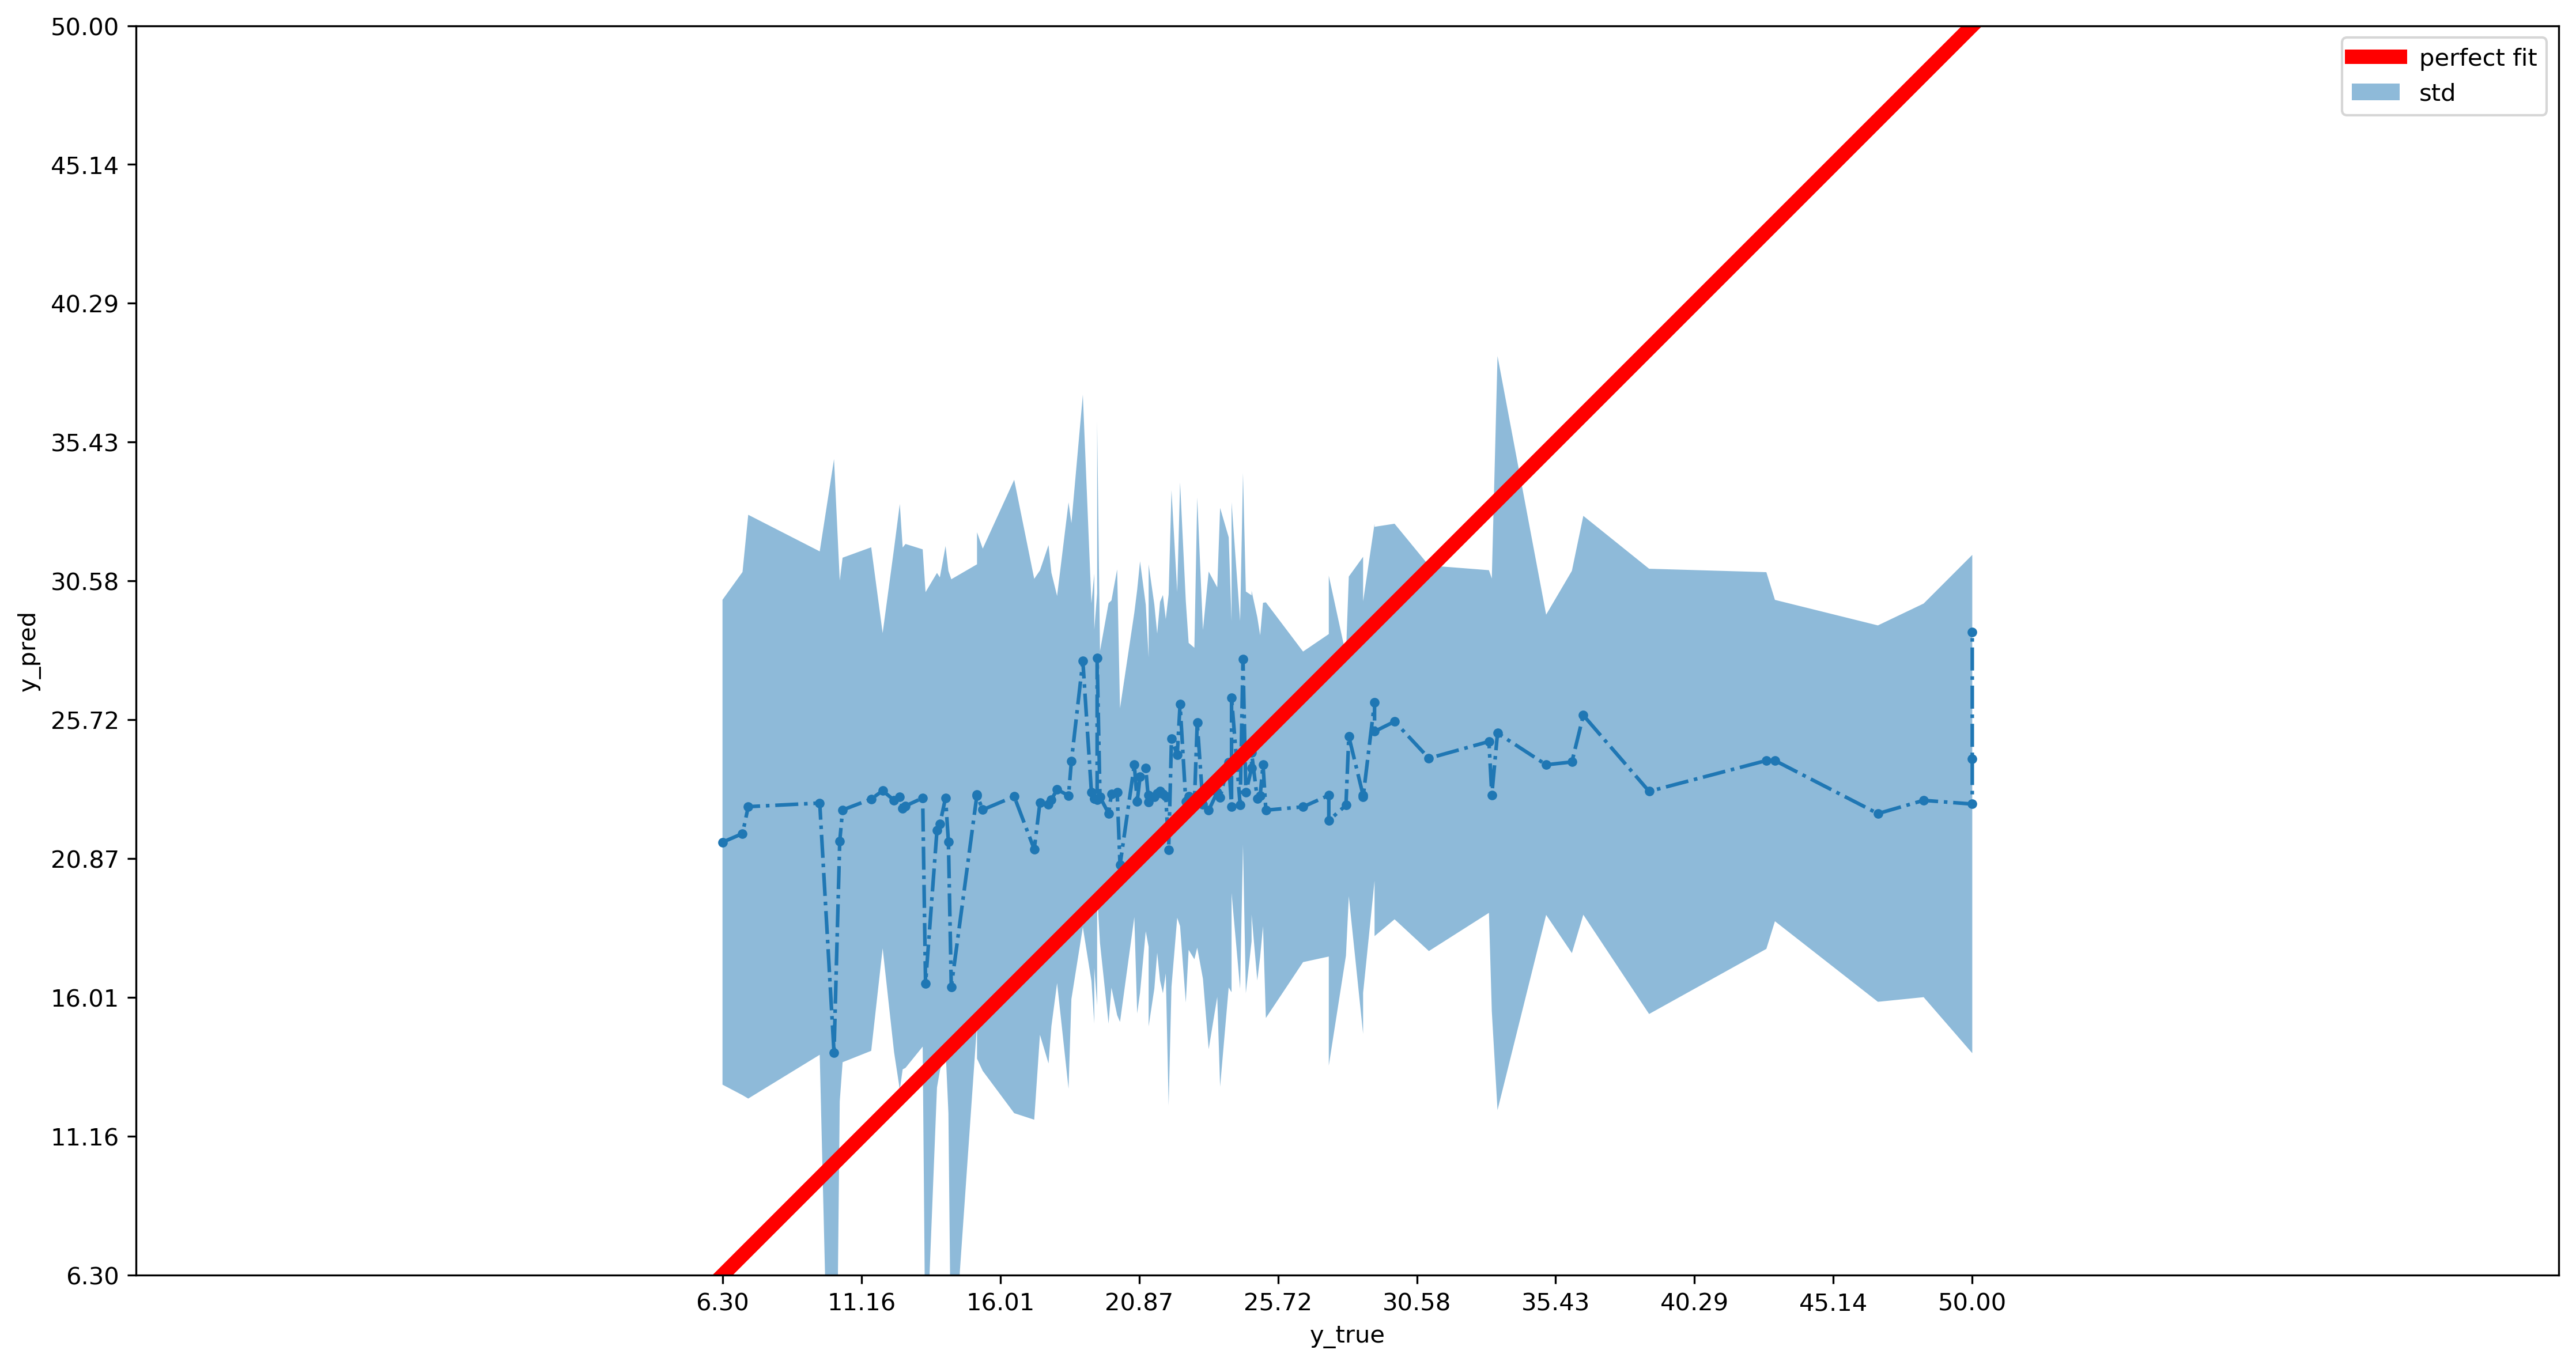

(array([[9.91655e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         3.38160e+02, 2.99700e+01],
        [1.83370e-01, 0.00000e+00, 2.77400e+01, ..., 2.01000e+01,
         3.44050e+02, 2.39700e+01],
        [1.68118e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         3.96900e+02, 3.08100e+01],
        ...,
        [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         3.75520e+02, 3.26000e+00],
        [6.11540e-01, 2.00000e+01, 3.97000e+00, ..., 1.30000e+01,
         3.89700e+02, 5.12000e+00],
        [2.00900e-02, 9.50000e+01, 2.68000e+00, ..., 1.47000e+01,
         3.90550e+02, 2.88000e+00]], dtype=float32),
 array([ 6.3,  7. ,  7.2,  9.7, 10.2, 10.4, 10.5, 11.5, 11.9, 12.3, 12.5,
        12.6, 12.7, 13.3, 13.4, 13.8, 13.9, 14.1, 14.2, 14.3, 15.2, 15.2,
        15.4, 16.5, 17.2, 17.4, 17.7, 17.8, 18. , 18.4, 18.5, 18.9, 19.2,
        19.3, 19.3, 19.4, 19.4, 19.5, 19.8, 19.9, 20.1, 20.2, 20.7, 20.8,
        20.9, 21.1, 21.2, 21.2, 21.4, 21.5, 21.6, 21.7, 21.8, 

In [9]:
plot_pred_to_true(model, dataset)